# Proyek Klasifikasi Gambar: [7 Spesies Bunga](https://www.kaggle.com/datasets/nadyana/flowers/data)
- **Nama:** Muhammad Tsaqiif Ash-Shiddiq
- **Email:** muhammadtsaqiif.ash@gmail.com
- **ID Dicoding:** muhammadtsaqiifash

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [5]:
!rm -rf flowers/

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d nadyana/flowers
!unzip flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/lotus/lotusnvevin.jpg  
  inflating: flowers/lotus/louts-flower-pond-close-up-petals-stamin-lotus-lily-144696984.jpg  
  inflating: flowers/lotus/macro-lotus-flower-13214393.jpg  
  inflating: flowers/lotus/macro-pink-lotus-flower-macro-pink-lotus-flower-close-up-pink-lotus-flower-raining-sunlight-morning-159065830.jpg  
  inflating: flowers/lotus/maxresdefault1.jpg  
  inflating: flowers/lotus/micro_-shot_-of_-a_-white_-lotus_-flower_-micro_-shot_-of_-a_-white_-lotus_-flower_-with_-green_-159427226.jpg  
  inflating: flowers/lotus/national_flower_inner.jpg  
  inflating: flowers/lotus/ndsfgiw.png  
  inflating: flowers/lotus/nelumbo-nucifera-flower-also-known-as-indian-lotus-sacred-lotus-bean-india-egyptian-bean-simply-lotus-nelumbo-nucifera-143764558.jpg  
  inflating: flowers/lotus/nelumbo_2.jpg  
  inflating: flowers/lotus/nlevnwoejr.jpg  
  inflating: flowers/lotus/p9ihfe5f.png  
  inflating: flowers/lotus/pex

**Plot gambar sampel untuk semua kelas**

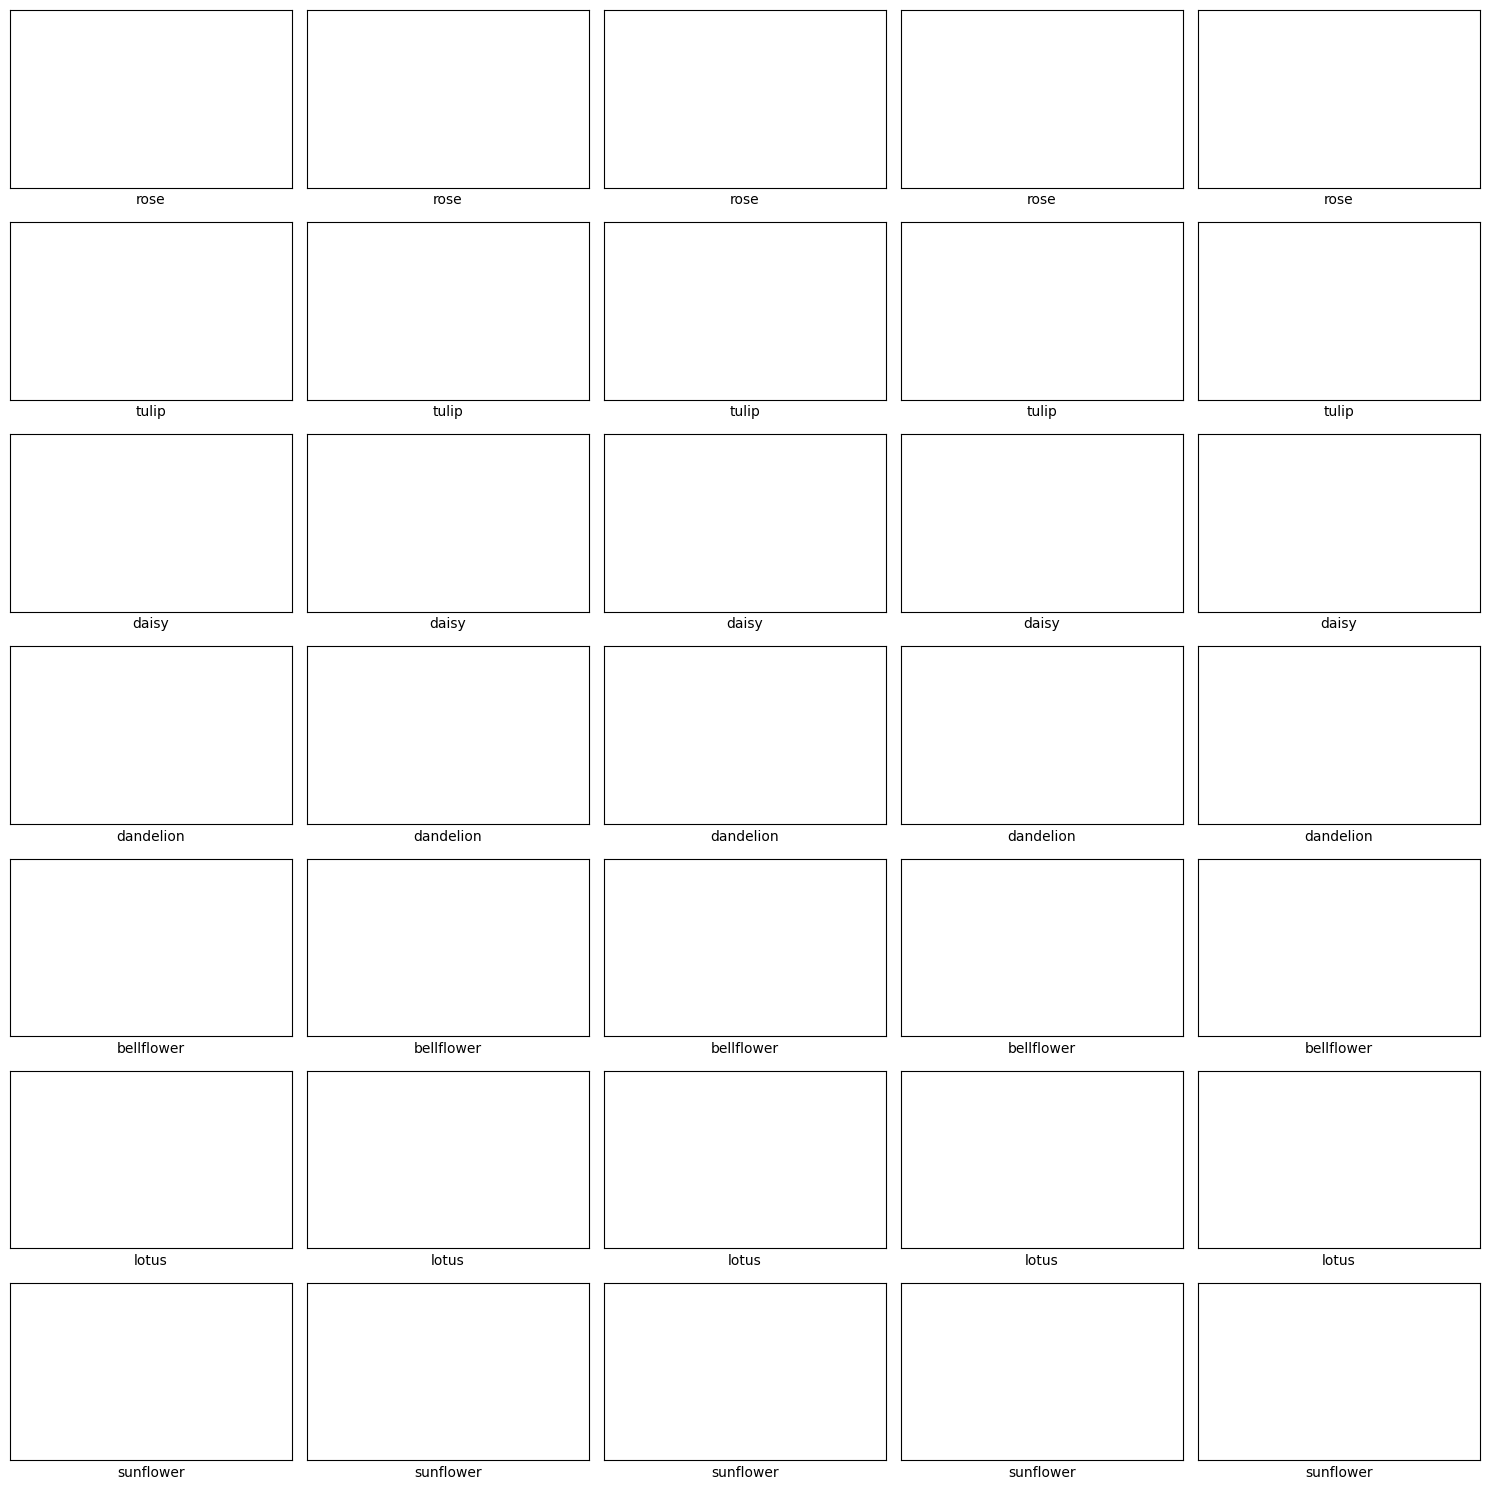

In [8]:
lung_image = {}

path = "flowers/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot distribusi gambar di seluruh kelas**

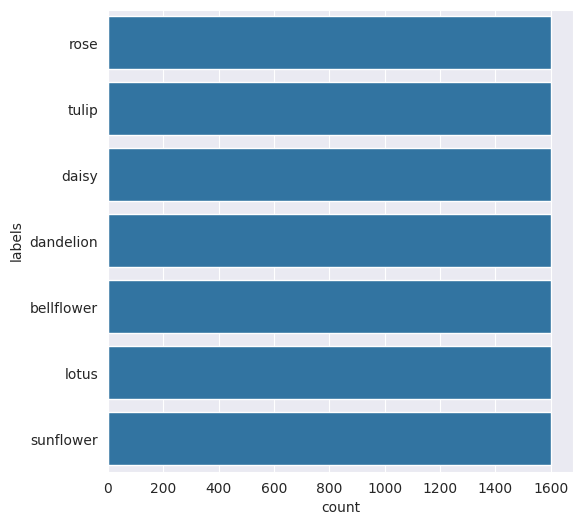

In [9]:
lung_path = "flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flowers/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
bellflower,1600
daisy,1600
dandelion,1600
lotus,1600
rose,1600
sunflower,1600
tulip,1600


In [11]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Menggunakan Stratify agar penyebaran seimbang**

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

train size 8960
test size 2240


In [13]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels    
test   bellflower     320
       daisy          320
       dandelion      320
       lotus          320
       rose           320
       sunflower      320
       tulip          320
train  bellflower    1280
       daisy         1280
       dandelion     1280
       lotus         1280
       rose          1280
       sunflower     1280
       tulip         1280
dtype: int64 


                                                    path      labels    set
7350                       flowers/daisy/image_02190.jpg       daisy  train
2573              flowers/tulip/110147301_ad921e2828.jpg       tulip  train
10857  flowers/lotus/lotus-flower-reflection-beautifu...       lotus   test
587                    flowers/bellflower/8b5fb2a9b7.jpg  bellflower  train
2037   flowers/rose/yellow-orange-color-rose-flower-c...        rose  train


In [14]:
datasource_path = "flowers/"
dataset_path = "Dataset-Final/"

In [15]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [16]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_bellflower = os.path.join(TRAIN_DIR, 'bellflower')
train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_lotus = os.path.join(TRAIN_DIR, 'lotus')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulip = os.path.join(TRAIN_DIR, 'tulip')

test_bellflower = os.path.join(TEST_DIR, 'bellflower')
test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_lotus = os.path.join(TEST_DIR, 'lotus')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulip = os.path.join(TEST_DIR, 'tulip')

print("Total number of bellflower images in training set: ", len(os.listdir(train_bellflower)))
print("Total number of daisy images in training set: ", len(os.listdir(train_daisy)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of lotus images in training set: ", len(os.listdir(train_lotus)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of tulips images in training set: ", len(os.listdir(train_tulip)))

print("Total number of bellflower images in test set: ", len(os.listdir(test_bellflower)))
print("Total number of daisy images in test set: ", len(os.listdir(test_daisy)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of lotus images in test set: ", len(os.listdir(test_lotus)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of tulips images in test set: ", len(os.listdir(test_tulip)))

Total number of bellflower images in training set:  1280
Total number of daisy images in training set:  1280
Total number of dandelion images in training set:  1280
Total number of lotus images in training set:  1280
Total number of rose images in training set:  1280
Total number of sunflower images in training set:  1280
Total number of tulips images in training set:  1280
Total number of bellflower images in test set:  320
Total number of daisy images in test set:  320
Total number of dandelion images in test set:  320
Total number of lotus images in test set:  320
Total number of rose images in test set:  320
Total number of sunflower images in test set:  320
Total number of tulips images in test set:  320


In [17]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=10,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    subset=None,
    shuffle=False
)

Found 7168 images belonging to 7 classes.
Found 1792 images belonging to 7 classes.
Found 2240 images belonging to 7 classes.


## Modelling

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [19]:
from tensorflow.keras import regularizers
model_32 = Sequential([
    # 1st Convolutional Block
    # Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.0005))
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(32, (4, 4), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Dense + Dropout layers
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model_32.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [21]:
print(model_32.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,288,007 (12.54 MB)

 Trainable params: 3,287,815 (12.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [22]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target=0.85, patience=5):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.monitor = monitor
        self.target = target
        self.patience = patience
        self.wait = 0
        self.stopping_triggered = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)

        if current is None:
            return

        if current >= self.target:
            if not self.stopping_triggered:
                self.stopping_triggered = True
                self.wait = 0

            else:
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training: {self.monitor} sudah >= {self.target} dan patience {self.patience} habis.")
                self.wait += 1
        else:
            self.wait = 0

In [23]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_accuracy = EarlyStoppingAtAccuracy(monitor='val_accuracy', target=0.85, patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

In [30]:
history_32 = model_32.fit(
    train_generator,
    epochs=60,
    batch_size=16,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_accuracy, reduce_lr]
)

Epoch 1/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6663 - loss: 1.7984
Epoch 1: val_accuracy did not improve from 0.75725
448/448 ━━━━━━━━━━━━━━━━━━━━ 128s 273ms/step - accuracy: 0.6662 - loss: 1.7985 - val_accuracy: 0.6853 - val_loss: 1.7111 - learning_rate: 1.0000e-04
Epoch 2/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6554 - loss: 1.8147
Epoch 2: val_accuracy did not improve from 0.75725
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.6554 - loss: 1.8147 - val_accuracy: 0.7031 - val_loss: 1.6910 - learning_rate: 1.0000e-04
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6537 - loss: 1.8004
Epoch 3: val_accuracy did not improve from 0.75725
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.6537 - loss: 1.8004 - val_accuracy: 0.7148 - val_loss: 1.6767 - learning_rate: 1.0000e-04
Epoch 4/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6808 - loss: 1.7342
Epoch 4: val_accuracy did not improve from 0.757

448/448 ━━━━━━━━━━━━━━━━━━━━ 124s 277ms/step - accuracy: 0.7440 - loss: 1.4122 - val_accuracy: 0.7773 - val_loss: 1.3142 - learning_rate: 1.0000e-04
Epoch 16/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7544 - loss: 1.3601
Epoch 16: val_accuracy did not improve from 0.77734
448/448 ━━━━━━━━━━━━━━━━━━━━ 126s 281ms/step - accuracy: 0.7543 - loss: 1.3601 - val_accuracy: 0.7533 - val_loss: 1.3474 - learning_rate: 1.0000e-04
Epoch 17/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7695 - loss: 1.3009
Epoch 17: val_accuracy did not improve from 0.77734
448/448 ━━━━━━━━━━━━━━━━━━━━ 123s 275ms/step - accuracy: 0.7695 - loss: 1.3010 - val_accuracy: 0.7427 - val_loss: 1.3986 - learning_rate: 1.0000e-04
Epoch 18/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7650 - loss: 1.3449
Epoch 18: val_accuracy did not improve from 0.77734
448/448 ━━━━━━━━━━━━━━━━━━━━ 123s 274ms/step - accuracy: 0.7650 - loss: 1.3448 - val_accuracy: 0.7751 - val_loss: 1.2727 - learnin

448/448 ━━━━━━━━━━━━━━━━━━━━ 123s 274ms/step - accuracy: 0.7874 - loss: 1.2437 - val_accuracy: 0.7930 - val_loss: 1.2357 - learning_rate: 1.0000e-04
Epoch 22/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7859 - loss: 1.2161
Epoch 22: val_accuracy did not improve from 0.79297
448/448 ━━━━━━━━━━━━━━━━━━━━ 123s 275ms/step - accuracy: 0.7859 - loss: 1.2161 - val_accuracy: 0.7790 - val_loss: 1.2950 - learning_rate: 1.0000e-04
Epoch 23/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8028 - loss: 1.1777
Epoch 23: val_accuracy did not improve from 0.79297
448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 273ms/step - accuracy: 0.8028 - loss: 1.1778 - val_accuracy: 0.7556 - val_loss: 1.3315 - learning_rate: 1.0000e-04
Epoch 24/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7983 - loss: 1.1993
Epoch 24: val_accuracy did not improve from 0.79297

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accu

448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8152 - loss: 1.1396 - val_accuracy: 0.8064 - val_loss: 1.1550 - learning_rate: 2.0000e-05
Epoch 26/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8280 - loss: 1.0875
Epoch 26: val_accuracy improved from 0.80636 to 0.80971, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8280 - loss: 1.0875 - val_accuracy: 0.8097 - val_loss: 1.1234 - learning_rate: 2.0000e-05
Epoch 27/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8355 - loss: 1.0391
Epoch 27: val_accuracy improved from 0.80971 to 0.82422, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8355 - loss: 1.0391 - val_accuracy: 0.8242 - val_loss: 1.0823 - learning_rate: 2.0000e-05
Epoch 28/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8361 - loss: 1.0465
Epoch 28: val_accuracy did not improve from 0.82422
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8361 - loss: 1.0465 - val_accuracy: 0.8147 - val_loss: 1.0898 - learning_rate: 2.0000e-05
Epoch 29/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8460 - loss: 1.0047
Epoch 29: val_accuracy improved from 0.82422 to 0.82757, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 269ms/step - accuracy: 0.8459 - loss: 1.0048 - val_accuracy: 0.8276 - val_loss: 1.0541 - learning_rate: 2.0000e-05
Epoch 30/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8453 - loss: 0.9993
Epoch 30: val_accuracy did not improve from 0.82757
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8453 - loss: 0.9993 - val_accuracy: 0.8237 - val_loss: 1.0523 - learning_rate: 2.0000e-05
Epoch 31/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8436 - loss: 0.9794
Epoch 31: val_accuracy improved from 0.82757 to 0.82812, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8436 - loss: 0.9795 - val_accuracy: 0.8281 - val_loss: 1.0587 - learning_rate: 2.0000e-05
Epoch 32/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8502 - loss: 0.9797
Epoch 32: val_accuracy did not improve from 0.82812
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8502 - loss: 0.9796 - val_accuracy: 0.8136 - val_loss: 1.0545 - learning_rate: 2.0000e-05
Epoch 33/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8496 - loss: 0.9776
Epoch 33: val_accuracy improved from 0.82812 to 0.83092, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 269ms/step - accuracy: 0.8496 - loss: 0.9776 - val_accuracy: 0.8309 - val_loss: 1.0149 - learning_rate: 2.0000e-05
Epoch 34/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8549 - loss: 0.9485
Epoch 34: val_accuracy improved from 0.83092 to 0.83203, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 271ms/step - accuracy: 0.8549 - loss: 0.9485 - val_accuracy: 0.8320 - val_loss: 1.0016 - learning_rate: 2.0000e-05
Epoch 35/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8588 - loss: 0.9309
Epoch 35: val_accuracy did not improve from 0.83203
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 269ms/step - accuracy: 0.8588 - loss: 0.9310 - val_accuracy: 0.8225 - val_loss: 1.0255 - learning_rate: 2.0000e-05
Epoch 36/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8583 - loss: 0.9394
Epoch 36: val_accuracy improved from 0.83203 to 0.83315, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 272ms/step - accuracy: 0.8583 - loss: 0.9394 - val_accuracy: 0.8331 - val_loss: 0.9958 - learning_rate: 2.0000e-05
Epoch 37/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8515 - loss: 0.9341
Epoch 37: val_accuracy improved from 0.83315 to 0.83650, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 141s 270ms/step - accuracy: 0.8515 - loss: 0.9341 - val_accuracy: 0.8365 - val_loss: 0.9794 - learning_rate: 2.0000e-05
Epoch 38/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8575 - loss: 0.9154
Epoch 38: val_accuracy did not improve from 0.83650
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8575 - loss: 0.9154 - val_accuracy: 0.8354 - val_loss: 0.9827 - learning_rate: 2.0000e-05
Epoch 39/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8600 - loss: 0.9029
Epoch 39: val_accuracy did not improve from 0.83650
448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 272ms/step - accuracy: 0.8600 - loss: 0.9029 - val_accuracy: 0.8292 - val_loss: 0.9842 - learning_rate: 2.0000e-05
Epoch 40/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8582 - loss: 0.8980
Epoch 40: val_accuracy did not improve from 0.83650

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accur

448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 271ms/step - accuracy: 0.8690 - loss: 0.8626 - val_accuracy: 0.8421 - val_loss: 0.9462 - learning_rate: 4.0000e-06
Epoch 45/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8719 - loss: 0.8524
Epoch 45: val_accuracy improved from 0.84208 to 0.84375, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 143s 275ms/step - accuracy: 0.8719 - loss: 0.8524 - val_accuracy: 0.8438 - val_loss: 0.9417 - learning_rate: 4.0000e-06
Epoch 46/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8805 - loss: 0.8417
Epoch 46: val_accuracy did not improve from 0.84375
448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 273ms/step - accuracy: 0.8805 - loss: 0.8417 - val_accuracy: 0.8354 - val_loss: 0.9419 - learning_rate: 4.0000e-06
Epoch 47/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8691 - loss: 0.8594
Epoch 47: val_accuracy did not improve from 0.84375
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 271ms/step - accuracy: 0.8691 - loss: 0.8594 - val_accuracy: 0.8426 - val_loss: 0.9303 - learning_rate: 4.0000e-06
Epoch 48/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8832 - loss: 0.8240
Epoch 48: val_accuracy improved from 0.84375 to 0.84877, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 273ms/step - accuracy: 0.8832 - loss: 0.8241 - val_accuracy: 0.8488 - val_loss: 0.9361 - learning_rate: 4.0000e-06
Epoch 49/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8709 - loss: 0.8424
Epoch 49: val_accuracy did not improve from 0.84877
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.8710 - loss: 0.8424 - val_accuracy: 0.8432 - val_loss: 0.9415 - learning_rate: 4.0000e-06
Epoch 50/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8748 - loss: 0.8335
Epoch 50: val_accuracy did not improve from 0.84877

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 271ms/step - accuracy: 0.8748 - loss: 0.8335 - val_accuracy: 0.8410 - val_loss: 0.9575 - learning_rate: 4.0000e-06
Epoch 51/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8671 - loss: 0.8471
Epoch 51: val_accuracy did not improve from 0.84877
448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8671 - lo

## Evaluasi dan Visualisasi

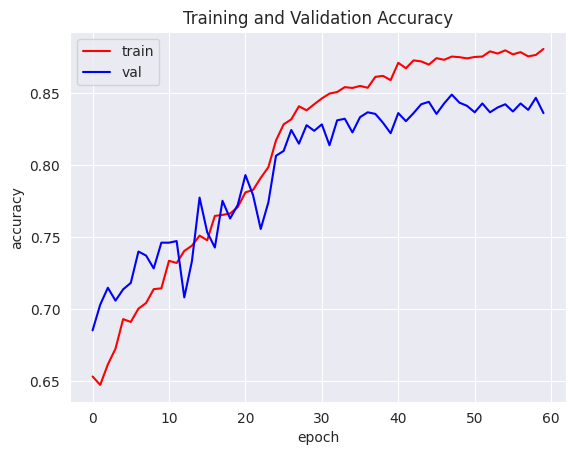

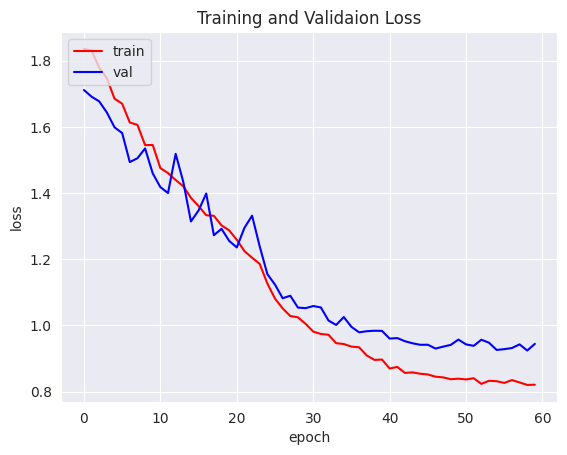

In [31]:
acc = history_32.history['accuracy']
val_acc = history_32.history['val_accuracy']
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

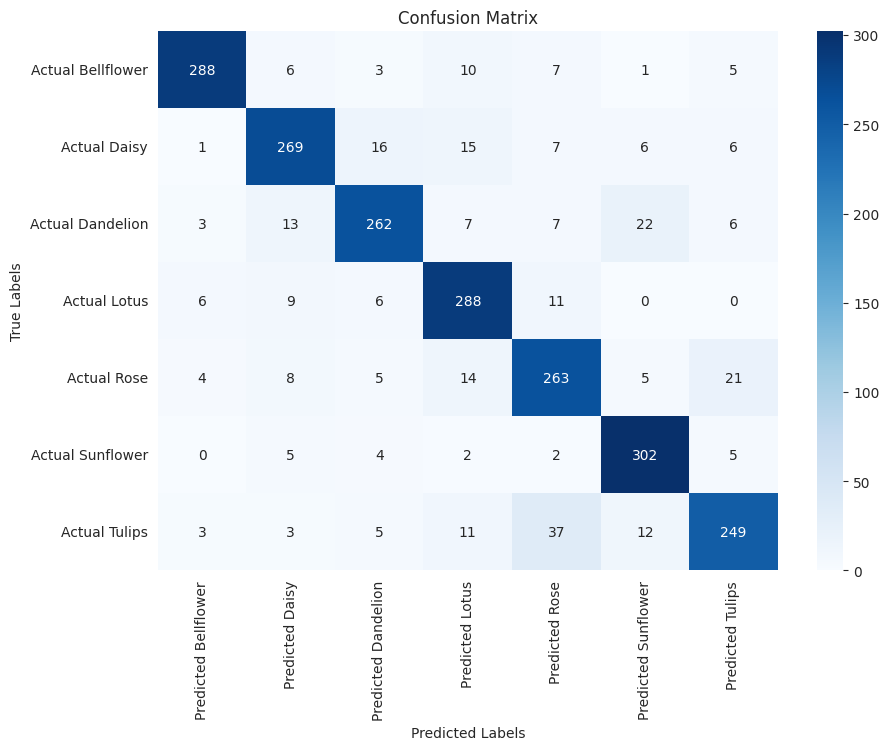



              precision    recall  f1-score   support

  bellflower     0.9443    0.9000    0.9216       320
       daisy     0.8594    0.8406    0.8499       320
   dandelion     0.8704    0.8187    0.8438       320
       lotus     0.8300    0.9000    0.8636       320
        rose     0.7874    0.8219    0.8043       320
   sunflower     0.8678    0.9437    0.9042       320
      tulips     0.8527    0.7781    0.8137       320

    accuracy                         0.8576      2240
   macro avg     0.8589    0.8576    0.8573      2240
weighted avg     0.8589    0.8576    0.8573      2240



In [32]:
test_generator.reset()

preds_1 = model_32.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),
                  index=["Actual Bellflower", "Actual Daisy", "Actual Dandelion", "Actual Lotus", "Actual Rose", "Actual Sunflower", "Actual Tulips"],
                  columns=["Predicted Bellflower", "Predicted Daisy", "Predicted Dandelion", "Predicted Lotus", "Predicted Rose", "Predicted Sunflower", "Predicted Tulips"])

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulips'],
                            digits=4))

## Konversi Model

In [35]:
os.makedirs("/content/models", exist_ok=True)

**savedmodel**

In [37]:
model_32.save("/content/models/saved_model.keras")

In [40]:
model_32.export("/content/saved_model")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138672528685008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672528685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529180240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529180624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529179856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529179664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672528685392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529181584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138672529178896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386725291

In [41]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 71%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/saved_model.pb (deflated 87%)


In [44]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TensorFlow Lite**

In [47]:
os.makedirs('/content/tflite', exist_ok=True)

In [49]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')

tflite_model = converter.convert()

with open('/content/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [50]:
class_names = ['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']

with open('/content/tflite/label.txt', 'w') as f:
    for name in class_names:
        f.write(name + '\n')

In [51]:
!zip -r /content/tflite.zip /content/tflite
from google.colab import files
files.download('/content/tflite.zip')

  adding: content/tflite/ (stored 0%)
  adding: content/tflite/model.tflite (deflated 9%)
  adding: content/tflite/label.txt (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TensorFlow.js**

In [45]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/saved_model /content/tfjs_model

2025-04-28 20:04:32.788214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745870672.820233   52473 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745870672.830343   52473 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-28 20:04:37.743227: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745870677.743392   52473 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [46]:
!zip -r /content/tfjs_model.zip /content/tfjs_model
from google.colab import files
files.download('/content/tfjs_model.zip')

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard4of4.bin (deflated 6%)
  adding: content/tfjs_model/model.json (deflated 91%)
  adding: content/tfjs_model/group1-shard1of4.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard3of4.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard2of4.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [53]:
model = tf.keras.models.load_model('/content/best_model.h5')

In [54]:
img_path = 'flowers/bellflower/0.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = img_array / 255.0

img_array = tf.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
[[9.9398440e-01 9.0288301e-04 1.6315829e-04 1.2039628e-03 6.9173088e-04
  3.3813824e-06 3.0503909e-03]]


In [55]:
predicted_class_index = np.argmax(predictions)

class_labels = ['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']

predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class label: {predicted_class_label}")

Predicted class label: bellflower


In [38]:
!pip freeze > requirements.txt